In [1]:
import os, time
import sys
sys.path.insert(1, '../')
from concentration import clt_iid, binomial_iid, pp_mean_iid_asymptotic
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import cv2 as cv
from PIL import Image
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from cache_ballots import find_ellipse
import pdb

## Load data

Unpack the hand-labeled data along with the predictions.
We used `cache_ballots.py` to produce this `.npz` file.

In [2]:
# Load data
data = np.load('./ballot-data.npz')
Y_labeled,  Yhat_labeled, Yhat_unlabeled = data['Y_labeled'], data['Yhat_labeled'], data['Yhat_unlabeled']

## Problem setup

Set up the inference parameters for the election result confidence interval.

In [3]:
alpha = 0.05
n_max = Y_labeled.shape[0] # Total number of labeled ballots
ns = np.linspace(100,n_max,20).astype(int)
num_trials = 500

# Reported result (official outcome)
reported_estimate = 0.6237

## Main experiment

Construct the imputed, classical, and prediction-powered confidence intervals for each value of `n`. 

Average the results for each `n` over `num_trials`.

In [4]:
# Imputed-only estimate
imputed_estimate = (Yhat_labeled.sum() + Yhat_unlabeled.sum())/(Yhat_labeled.shape[0] + Yhat_unlabeled.shape[0])

# Run prediction-powered inference and classical inference for many values of n
ci = np.zeros((num_trials, ns.shape[0], 2))
ci_classical = np.zeros((num_trials, ns.shape[0], 2))

for i in tqdm(range(ns.shape[0])):
    for j in range(num_trials):
        # Prediction-Powered Inference
        n = ns[i]
        rand_idx = np.random.permutation(n)
        f = Yhat_labeled.astype(float)[rand_idx[:n]]
        y = Y_labeled.astype(float)[rand_idx[:n]]
                
        ci[j,i,:] = pp_mean_iid_asymptotic(y,f,Yhat_unlabeled,alpha)

        # Classical interval
        ci_classical[j,i,:] = binomial_iid(n,alpha,y.mean())
        
ci_imputed = binomial_iid(Yhat_unlabeled.shape[0], alpha, imputed_estimate)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.71it/s]


## Plot election results.

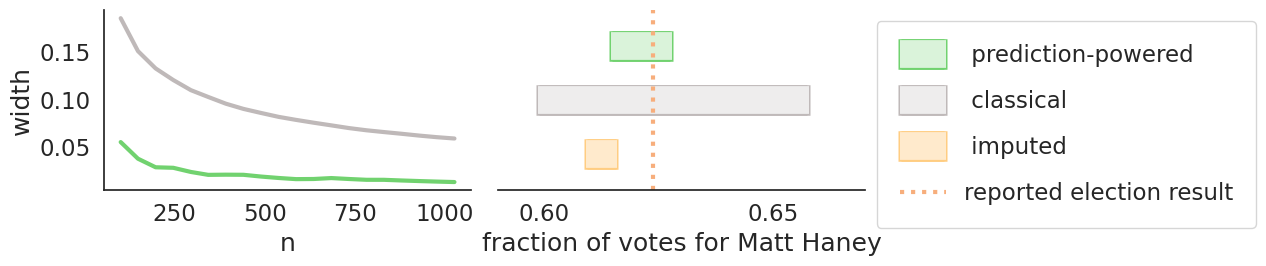

In [5]:
# Plots
os.makedirs('./figures', exist_ok=True)
sns.set_theme(style='white', font_scale=1.5, font="DejaVu Sans")

avg_ci = ci.mean(axis=0)[-1]
avg_ci_classical = ci_classical.mean(axis=0)[-1]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13,3))

# Intervals
axs[1].plot(avg_ci,[0.4,0.4], linewidth=20, color="#DAF3DA", path_effects=[pe.Stroke(linewidth=22, offset=(-1,0), foreground="#71D26F"), pe.Stroke(linewidth=22, offset=(1,0), foreground="#71D26F"), pe.Normal()], label=' prediction-powered', solid_capstyle="butt")
axs[1].plot(avg_ci_classical,[0.25, 0.25], linewidth=20, color="#EEEDED", path_effects=[pe.Stroke(linewidth=22, offset=(-1,0), foreground="#BFB9B9"), pe.Stroke(linewidth=22, offset=(1,0), foreground="#BFB9B9"), pe.Normal()], label=' classical', solid_capstyle="butt")
axs[1].plot(ci_imputed,[0.1, 0.1], linewidth=20, color="#FFEACC", path_effects=[pe.Stroke(linewidth=22, offset=(-1,0), foreground="#FFCD82"), pe.Stroke(linewidth=22, offset=(1,0), foreground="#FFCD82"), pe.Normal()], label=' imputed', solid_capstyle="butt")
axs[1].axvline(reported_estimate, ymin=0.0, ymax=1, linestyle="dotted", linewidth=3, label="reported election result", color="#F7AE7C")
axs[1].set_xlabel("fraction of votes for Matt Haney")
axs[1].set_yticks([])
axs[1].set_yticklabels([])
axs[1].xaxis.set_tick_params()
axs[1].set_ylim([0,0.5])
axs[1].set_xlim([0.59, 0.67])
axs[1].locator_params(nbins=3)
axs[1].legend(borderpad=1, labelspacing=1, bbox_to_anchor=(1,1))
sns.despine(ax=axs[1],top=True,right=True,left=True)

# Lines
axs[0].plot(ns,ci.mean(axis=0)[:,1]-ci.mean(axis=0)[:,0], label="prediction-powered", color="#71D26F", linewidth=3)
axs[0].plot(ns, ci_classical.mean(axis=0)[:,1]-ci_classical.mean(axis=0)[:,0], label="classical", color="#BFB9B9", linewidth=3)
axs[0].locator_params(axis='y', tight=None, nbins=6)
axs[0].set_ylabel("width")
axs[0].set_xlabel("n")
sns.despine(ax=axs[0],top=True, right=True)
plt.tight_layout()

plt.savefig('./results.pdf')

## Visualize ballots

### This requires downloading the raw ballots from the following link: 
https://sfelections.sfgov.org/april-19-2022-election-results-detailed-reports

Click `Final Report/Ballot Images - Raw Images` to get the ballots.

Then run `./cache_ballots.py` to cache them as `.png` images to plot here.

Thereafter, the next cell will work.

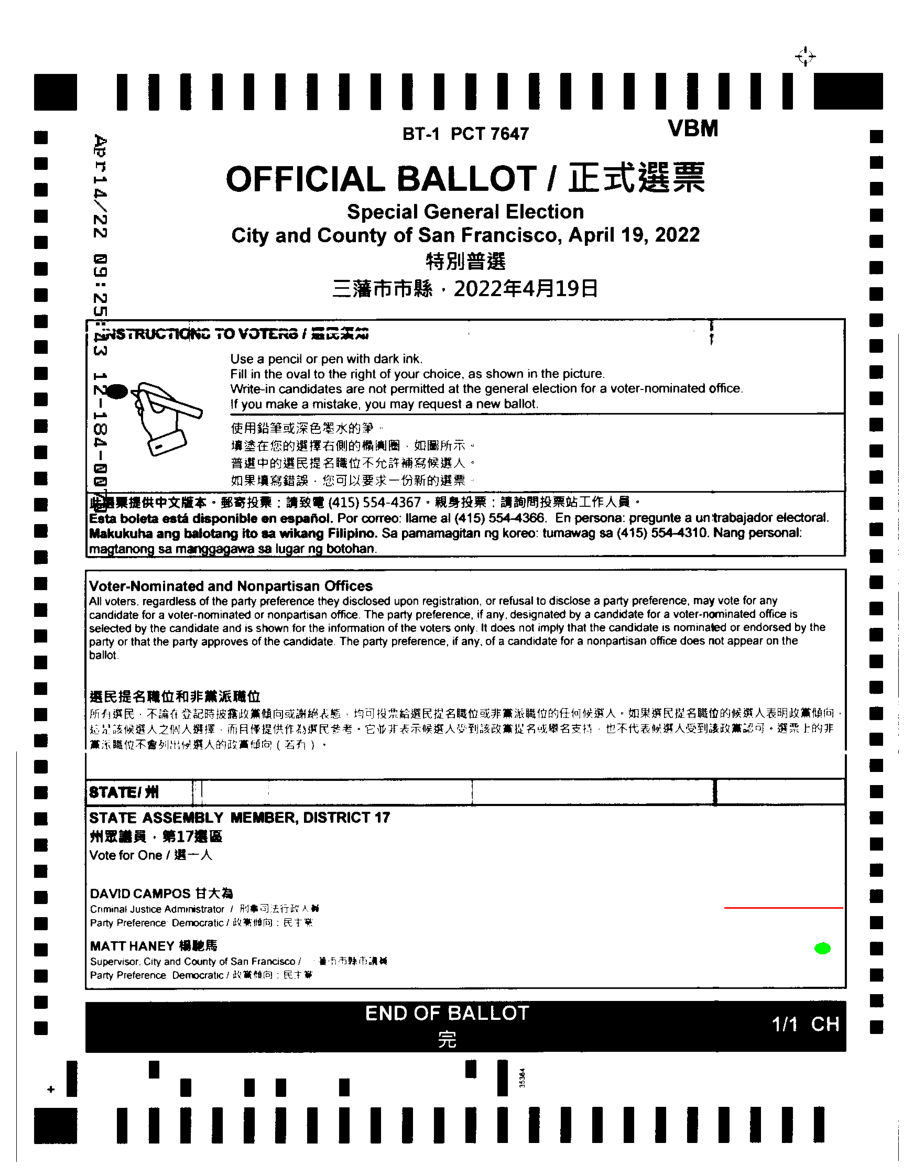

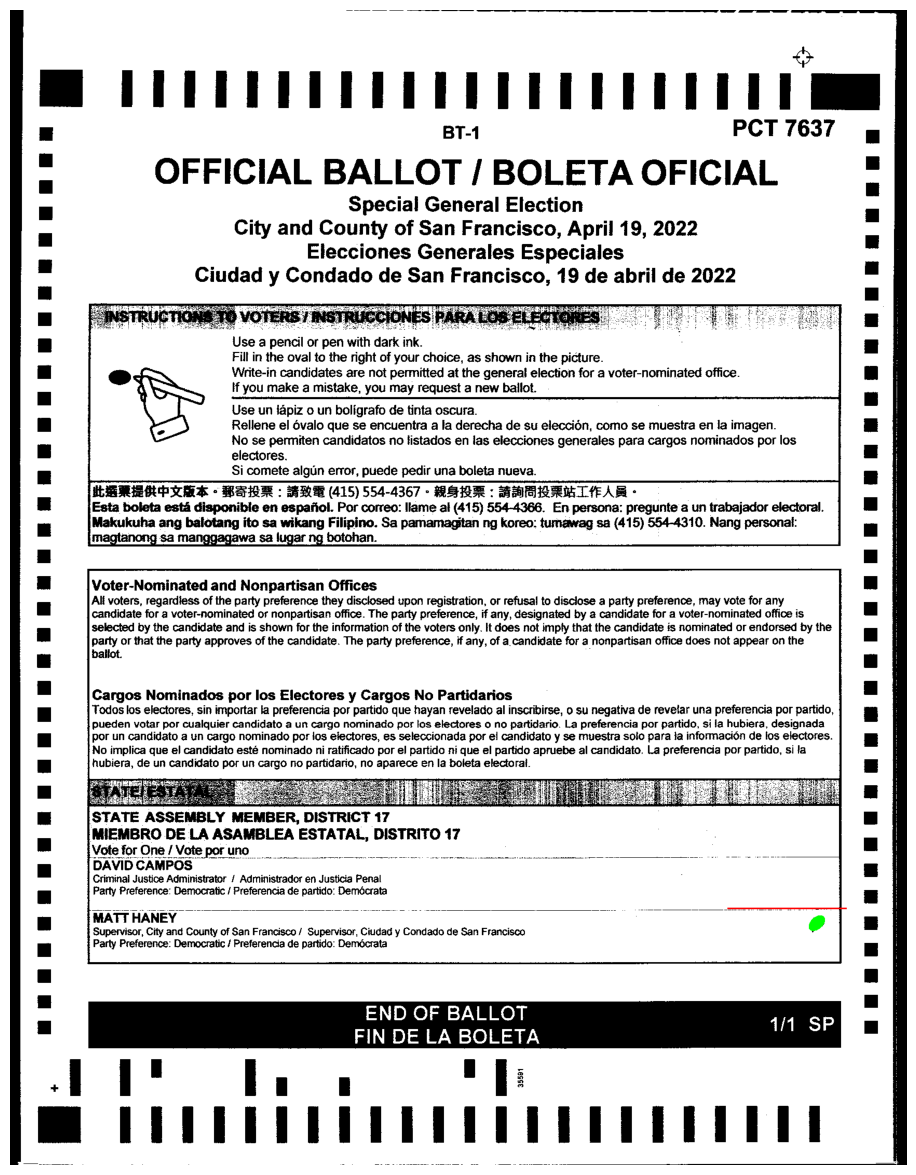

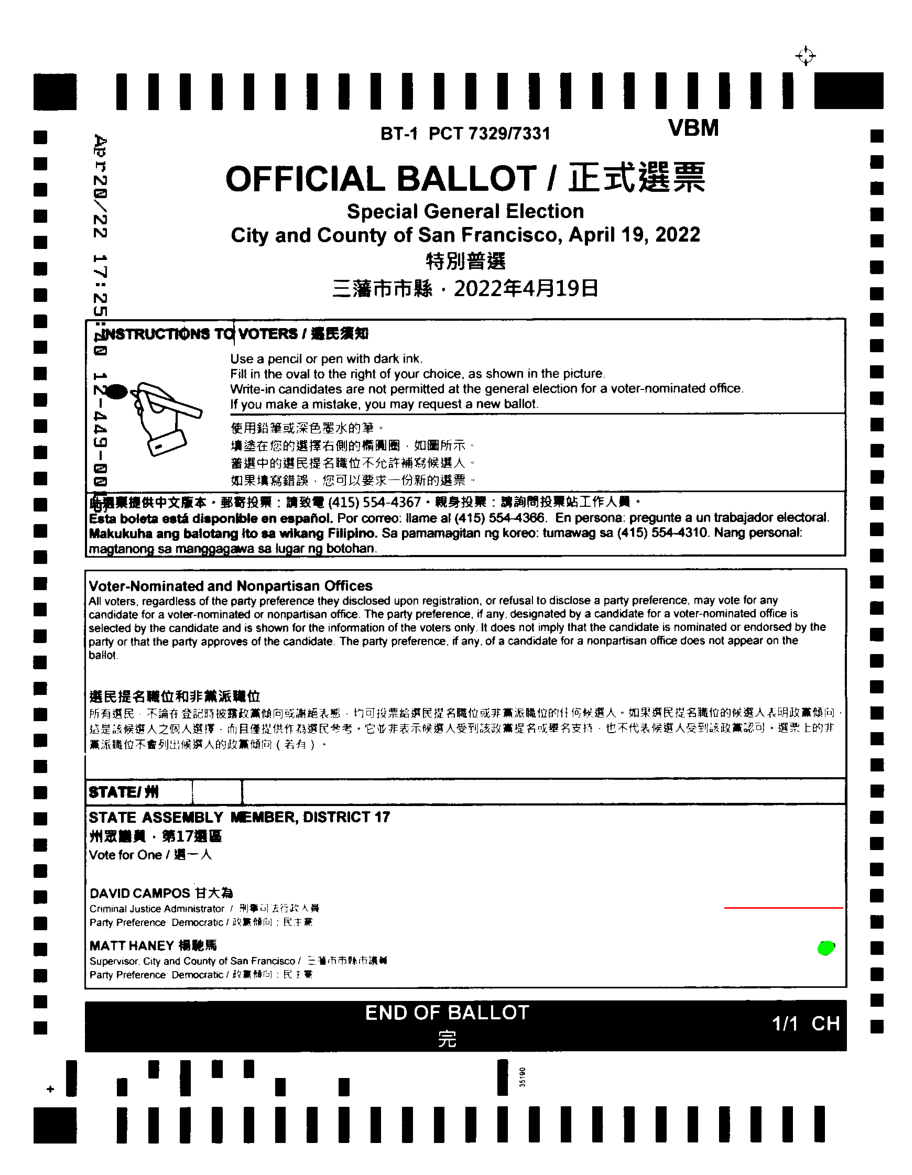

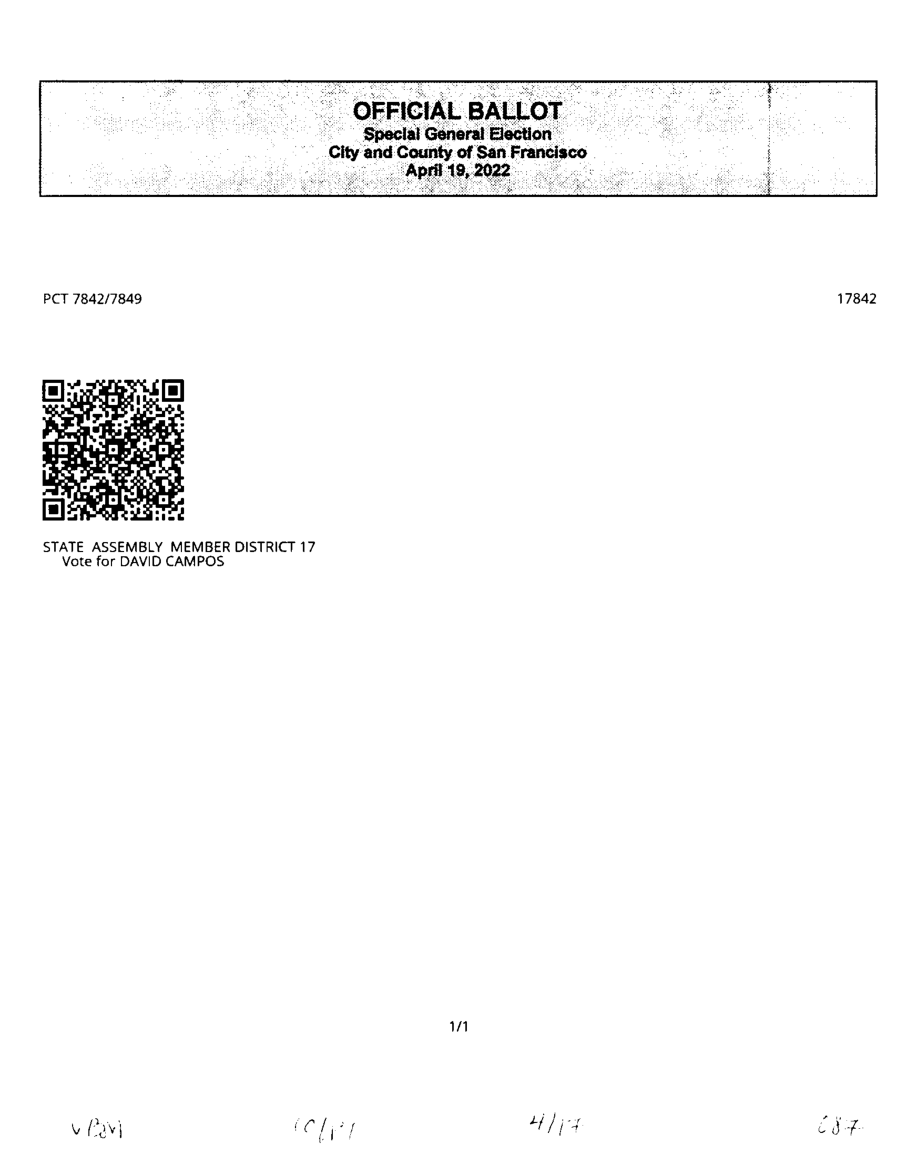

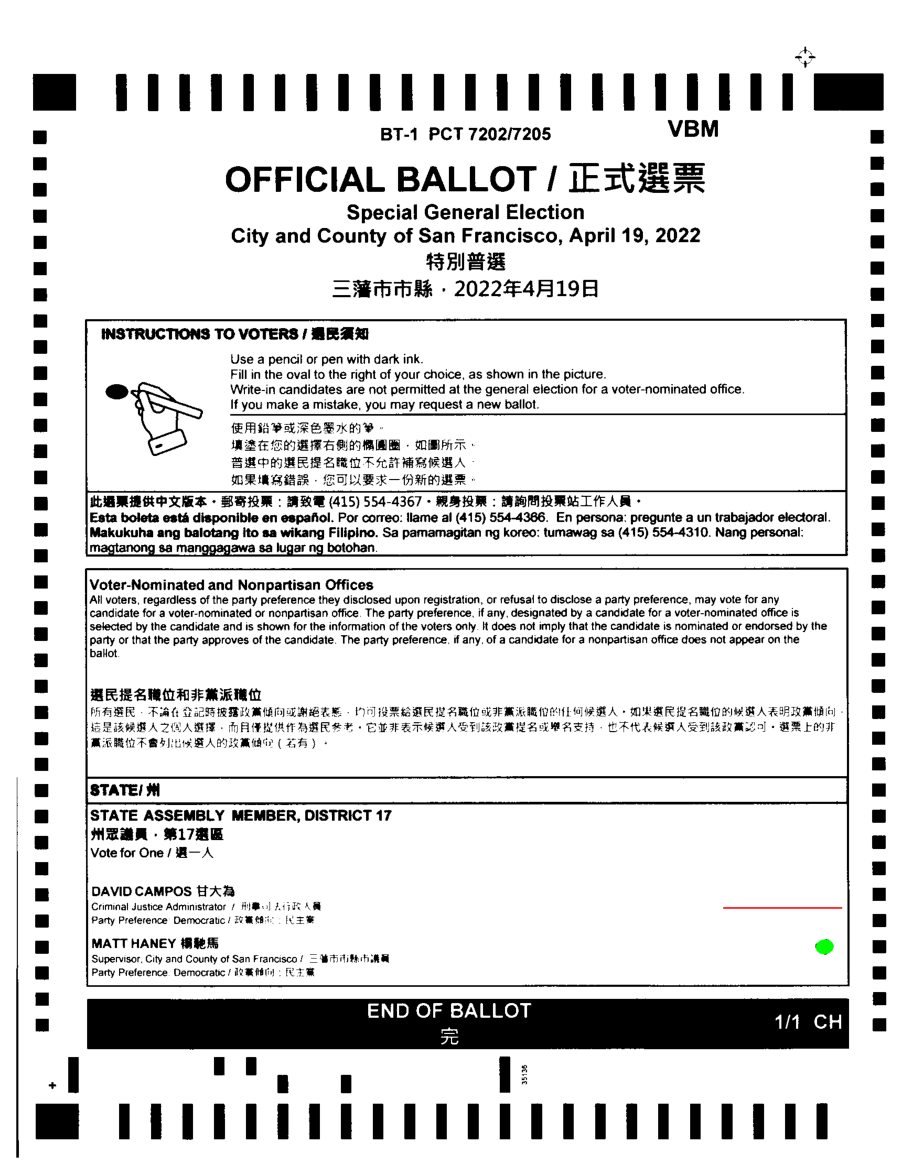

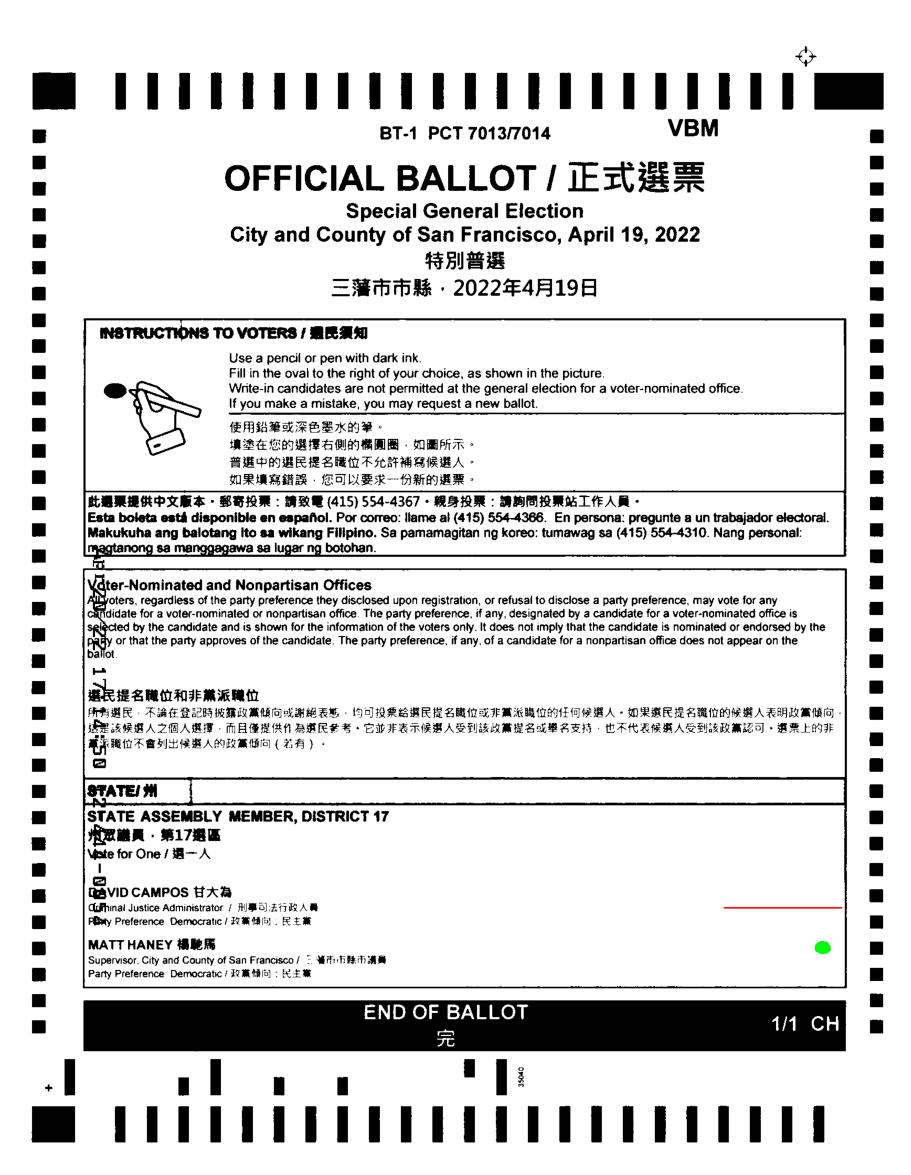

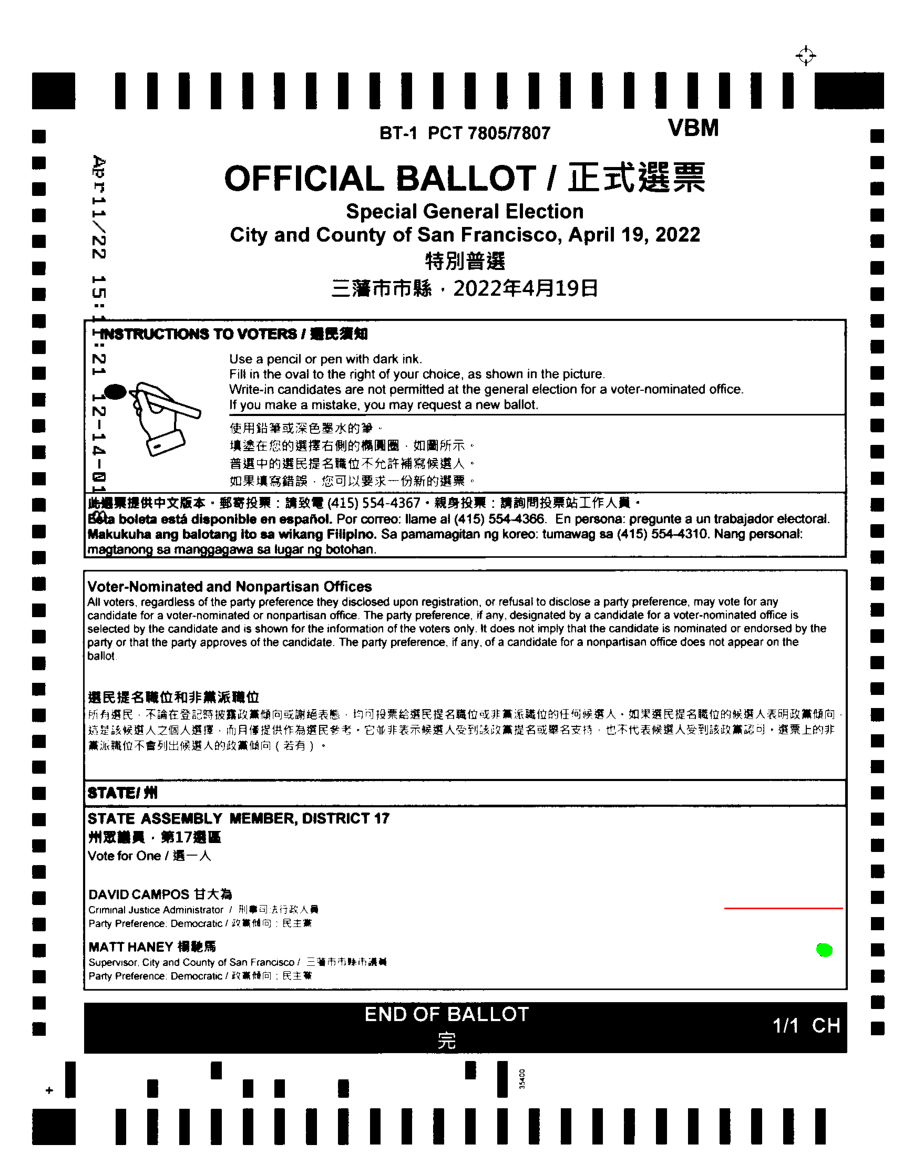

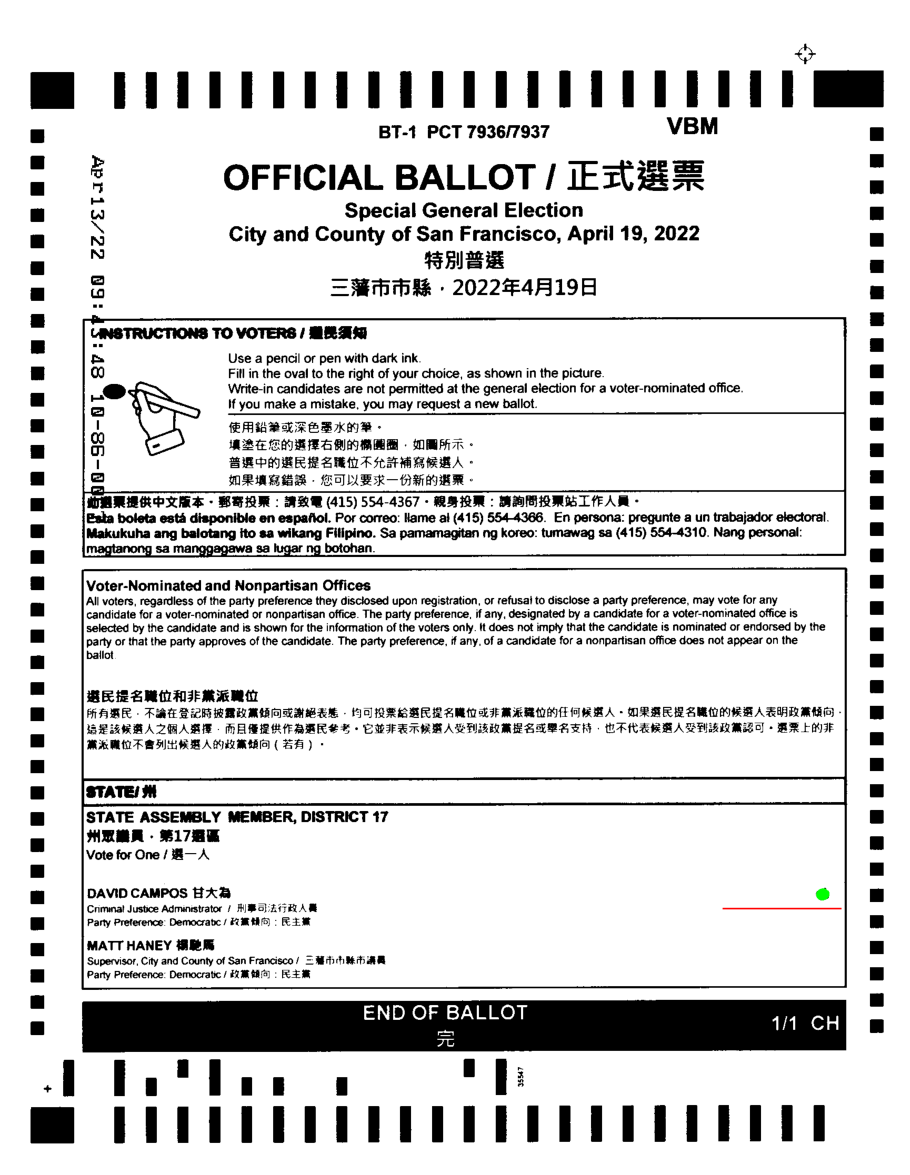

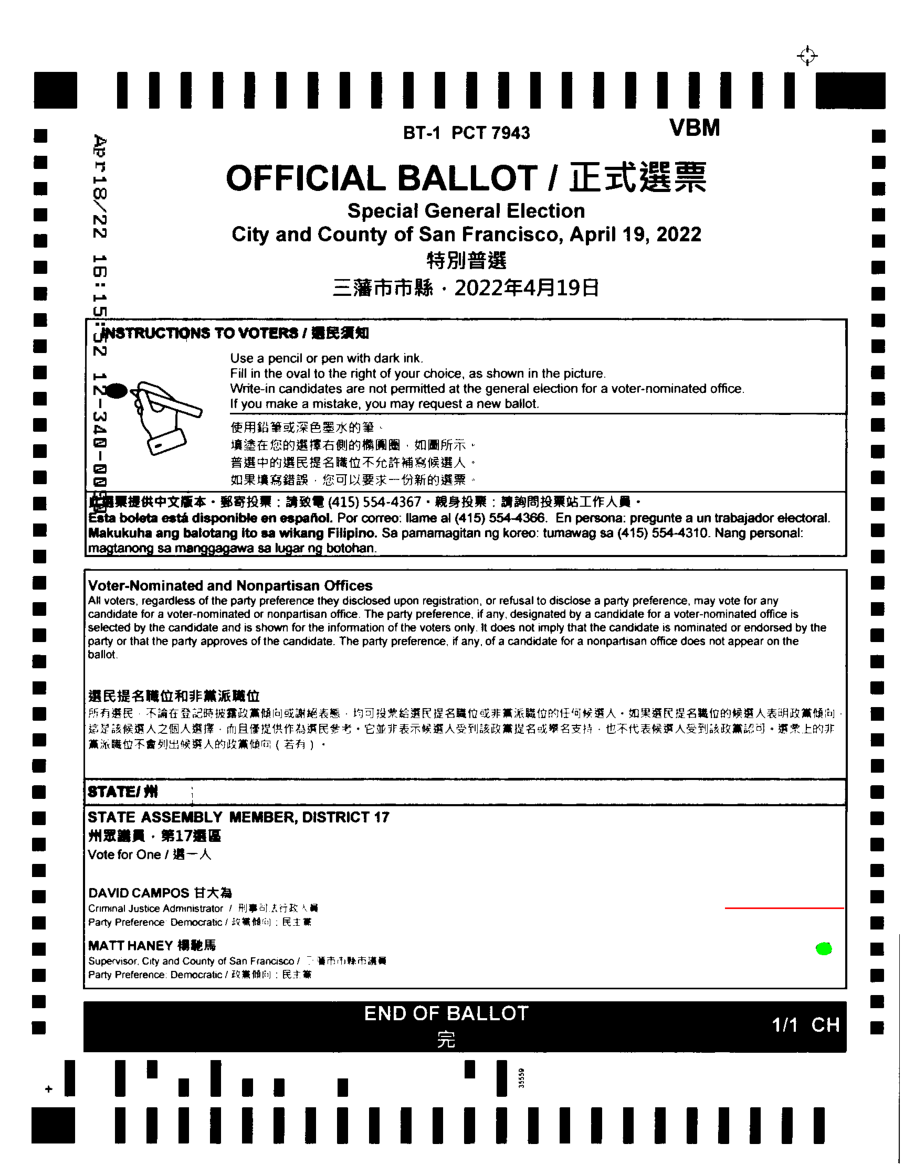

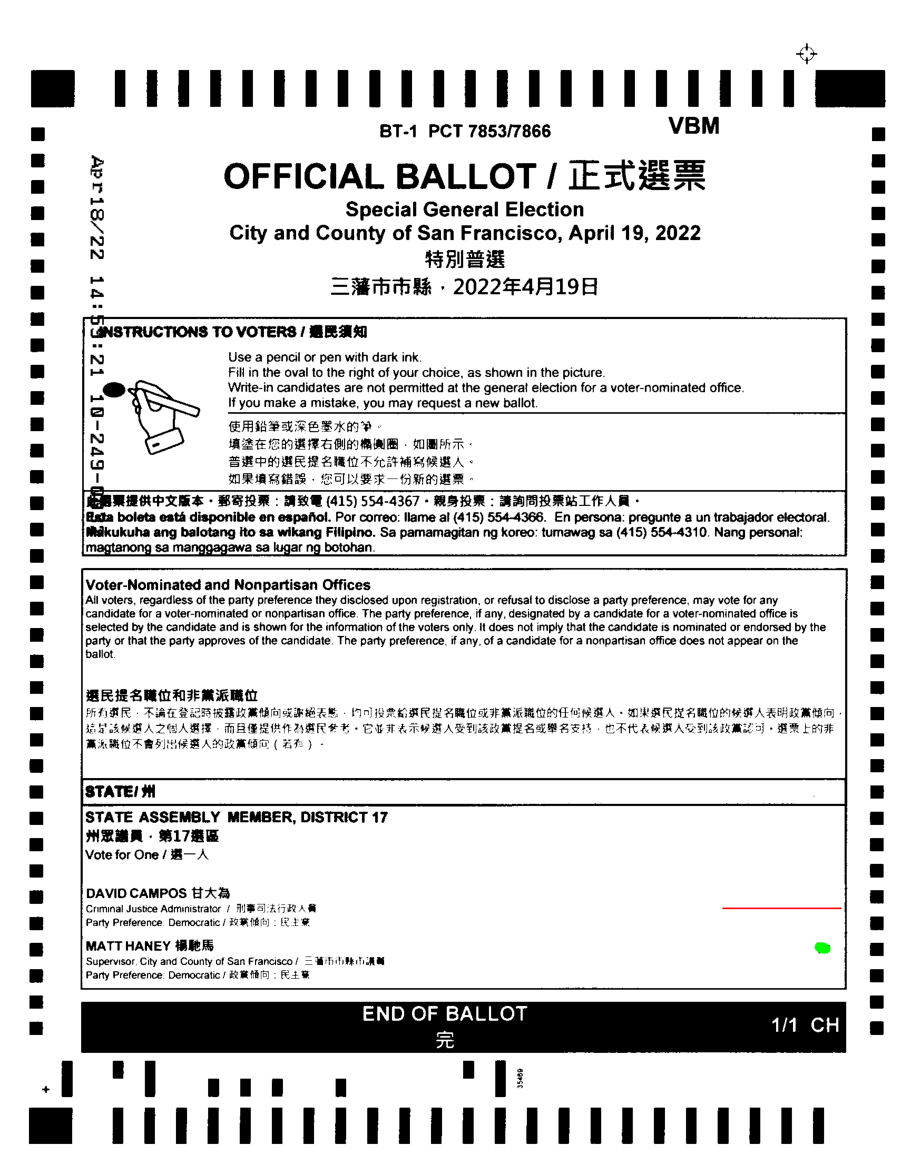

In [6]:
# Visualize data
base_path = "/Users/angelopoulos/Code/working/prediction-powered-inference/ballots/proc/"
ballot_filenames = []
for dirpath, dirnames, filenames in os.walk(base_path):
    for filename in filenames:
        if '.png' in filename:
            ballot_filenames += [dirpath + "/" + filename, ]
ballot_filenames = np.array(ballot_filenames)
ballot_filenames = np.random.choice(ballot_filenames, 10)
[find_ellipse(ballot_filename, plot=True) for ballot_filename in ballot_filenames];